In [93]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>


# Kopen of huren?

Al zolang ik me kan herinneren roept iedereen om mij heen dat een huis kopen absoluut een goede investering is.
In eerste instantie lijkt dit zeer aannemelijk, vooral door de zeer lage hypotheek die men nu kan afsluiten (≈2.0% voor 30 jaar vast).

Wat ik wil vergelijken is, wat beter is voor mijn portomonee na N jaar:
- een huis kopen met een hypotheek van €`X` per maand
- een huis huren voor €`Y` per maand (waar `X>Y`) en €`(X-Y`) (de rest) maandelijks investeren in de aandelenmarkt

In een simpele berekening kwam ik erachter dat het niet helemaal duidelijk is wat het beste is.
Het is namelijk sterk afhankelijk van hoeveel je huis in waarde stijgt en hoeveel de aandelenmarkt stijgt.
Bij een eerste benadering lijkt het dat als `aandelenmarkt_stijging_pct` ≈ `huis_waarde_stijging_pct`, een huiskopen absoluut een groot voordeel oplevert.
Echter, als de aandelenmarkt het bijvoorbeeld 2% beter doet (wat **zeer** aannemelijk is), is het niet helemaal duidelijk.

"The Devil is in de details," dus het is mijn plan om een realistische benadering te doen, uitgaande van de historische groei in de huizen- en aandelenmarkt, hyptotheekrenteaftrek, vermogensbelasting, huis onderhouds kosten, een annuïteitenhypotheek, Monte Carlo simulaties, WOZ belasting, loonheffing, inkomen, overdrachtsbelasting, statistiek, en meer...

Er zijn een aantal parameters die hierbij relevant zijn:

| parameter | waarde | variabel |
| --- | --- | --- |
| huis prijs | €X | ja |
| hypotheekrente | 2.0% | nee |
| hypotheek duur | 30 jaar | nee |
| hypotheek soort | annuïteitenhypotheek | nee |
| vaste kosten van een huiseigenaar | 1% huiswaarde per jaar | nee |
| huur huis | €Y per maand | ja |
| gemiddelde waardestijging huis | 5% per jaar | ja |
| gemiddelde waardestijging aandelenmarkt | 7% per jaar | ja |
| jaarinkomen | €50k | ja |
| (studie)schulden | €20k | ja |

\* met variabel bedoel ik dat ik de waarde van de parameter wel of niet vast zet in het numerieke experiment.

## Performance huizenmarkt sinds 1996

Ik heb de data van het [CBS](https://opendata.cbs.nl/#/CBS/nl/dataset/83906NED/table) gedownload met alle kwartaal data sinds 1996.

Het blijkt dat periodes in de afgelopen jaren zowel een flinke daling als een stijgingen gekent hebben.
Een paar voorbeeldjes:

| van | tot | lengte periode | gemiddeld prijsverschil | notities |
| --- | --- | --- | --- | --- |
| 2014Q2 | 2020Q4 | 6 jaar | 6% | de recente 'goede' jaren |
| 2009Q2 | 2014Q1 | 5 jaar | -4.1% | slechtste jaren na de 2008 crisis |
| 2009Q2 | 2020Q4 | 11 jaar | 1.6% | van 2008 crisis tot en met nu |
| 1996Q1 | 2020Q4 | 24 jaar | 5.1% | alle data sinds 1996 tot en met nu |

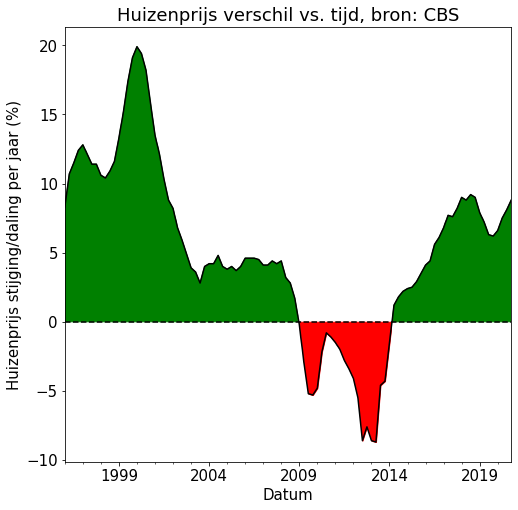

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

matplotlib.rc("font", size=15)
# Load the data
df_huis = pd.read_csv("huizenprijzen.csv", delimiter=";")
df_huis.Perioden = pd.to_datetime(
    df_huis.Perioden.str.replace("e kwartaal", "").str.replace(" ", "-Q")
)
df_huis.set_index("Perioden", inplace=True)

# Interpolate to daily and than select first days of the month
huis_relative = (
    df_huis["Prijsindex verkoopprijzen/Ontwikkeling  t.o.v. een jaar eerder (%)"]
    .resample("D")
    .interpolate()
)
huis_relative = huis_relative[huis_relative.index.day == 1]
huis_relative = huis_relative[~huis_relative.isna()]  # Drop NaNs
fig, ax = plt.subplots(figsize=(7, 7))
huis_relative.plot(
    ax=ax,
    legend=False,
    xlabel="Datum",
    ylabel="Huizenprijs stijging/daling per jaar (%)",
    title="Huizenprijs verschil vs. tijd, bron: CBS",
    figsize=(8, 8),
    color="k",
)


def fill_area(x, ax, alpha=1):
    ax.fill_between(
        x.index,
        x.values,
        where=x.values > 0,
        color="green",
        alpha=alpha,
        zorder=-1,
    )
    ax.fill_between(
        x.index,
        x.values,
        where=x.values < 0,
        color="red",
        alpha=alpha,
        zorder=-1,
    )
    ax.hlines(0, x.index.min(), x.index.max(), ls="--", color="k")


fill_area(huis_relative, ax)

## Performance aandelenmarkt

Mijn persoonlijke investeringsstrategie is om in de gehele wereldeconomie te investeren.
Zelf doe ik dit bij DeGiro in de [Vanguard VWRL ETF](https://www.vanguardinvestor.co.uk/investments/vanguard-ftse-all-world-ucits-etf-usd-distributing/overview).
Dit fonds bestaat pas sinds 2016, maar ik wil data van langer terug.
Gelukkig is deze index sterk gecorreleerd met de [S&P500](https://en.wikipedia.org/wiki/S%26P_500), waarvan de data gemakkelijk terug te vinden is tot 1950.


Ik heb de data van [Yahoo! Finance](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1588377600&interval=1d&filter=history&frequency=1d) gekopieerd van januari 1970 tot vandaag in een `csv` bestandje geplakt.

<AxesSubplot:title={'center':'S&P500 index vs. tijd, bron: Yahoo! Finance'}, xlabel='Datum', ylabel='S&P500 prijs ($)'>

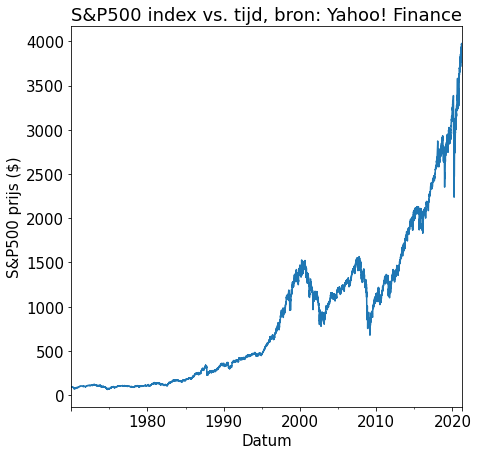

In [2]:
import numpy as np

# Daily data to need to resample it to quarterly like the huizenprijzen
df_stock = pd.read_csv("sp500.csv")
df_stock.Date = pd.to_datetime(df_stock.Date)
df_stock.set_index("Date", inplace=True)
# *Close price adjusted for splits
# **Adjusted close price adjusted for both dividends and splits.
stock_price = df_stock["Close*"].str.replace(",", "").astype(float)
# Create data points for each day
stock_price = stock_price.resample("D").interpolate()
stock_price.plot(
    xlabel="Datum",
    ylabel="S&P500 prijs ($)",
    title="S&P500 index vs. tijd, bron: Yahoo! Finance",
    figsize=(7, 7),
)

Deze data moet ik omzetten naar procent stijging/daling ten opzichte van een jaar geleden, zoals de huizenprijs data van het CBS.

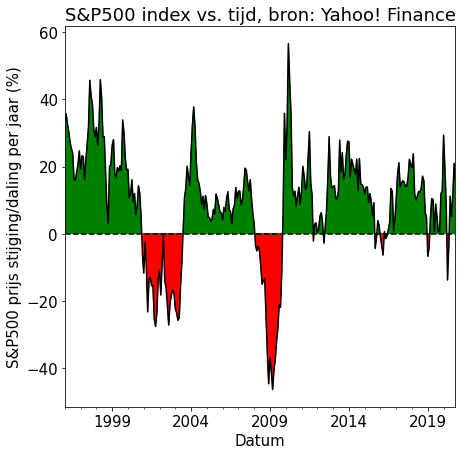

In [3]:
stock_price = stock_price[stock_price.index.day == 1]  # Keep only first of the month
first_year = stock_price.index.min().year
start = f"{first_year+1}-02-01"
end = stock_price.index.max()

stock_relative = {}
for date, value in stock_price[stock_price.index >= start].items():
    date_prev = date.replace(date.year - 1)
    prev = stock_price[date_prev]
    stock_relative[date] = (value - prev) / prev * 100
stock_relative = pd.Series(stock_relative)
# Select at same dates as huis prijzen
stock_relative = stock_relative[huis_relative.index]
fig, ax = plt.subplots(figsize=(7, 7))
stock_relative.plot(
    ax=ax,
    xlabel="Datum",
    ylabel="S&P500 prijs stijging/daling per jaar (%)",
    title="S&P500 index vs. tijd, bron: Yahoo! Finance",
    color="k",
)
fill_area(stock_relative, ax)

In [4]:
groei = pd.concat([huis_relative, stock_relative], axis=1, keys=["huis", "aandelen"])

In [5]:
print(
    f"Gemiddelde stijging per jaar sinds {stock_relative.index.min().year} is {stock_relative.mean():.2f}%"
)

Gemiddelde stijging per jaar sinds 1996 is 8.82%


Op het eerste oog lijkt de aandelenmarkt een stuk grilliger dan de huizenmarkt, met veel grotere verliezen, maar ook grotere winsten.

Laten we beide in de zelfde grafiek plotten met gemeenschappelijke periodes.

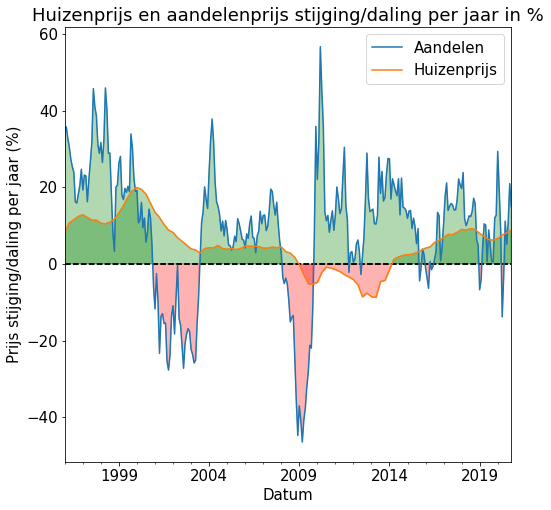

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
stock_relative[huis_relative.index].plot(ax=ax, label="Aandelen", legend=True)
huis_relative.plot(ax=ax, label="Huizenprijs", legend=True)
ax.set_title("Huizenprijs en aandelenprijs stijging/daling per jaar in %")
ax.set_xlabel("Datum")
ax.set_ylabel("Prijs stijging/daling per jaar (%)")
fill_area(stock_relative, ax, alpha=0.3)
fill_area(huis_relative, ax, alpha=0.3)

In de "Performance huizenmarkt" sectie aan het begin had ik een tabelletje met een aantal periodes waarin het goed of slecht ging. Laten we die periodes met elkaar vergelijken.

In [7]:
example_periods = [
    dict(van="2014-Q2", tot="2020-Q4", notities="de recente 'goede' jaren"),
    dict(van="2009-Q2", tot="2014-Q1", notities="slechtste jaren na de 2008 crisis"),
    dict(van="2009-Q2", tot="2020-Q4", notities="van 2008 crisis tot en met nu"),
    dict(van="1996-Q1", tot="2020-Q4", notities="alle data sinds 1996 tot en met nu"),
]

for dct in example_periods:
    mean = lambda x: x[(x.index >= dct["van"]) & (x.index <= dct["tot"])].mean()
    dct["huis"] = f"{mean(huis_relative):.2f}%"
    dct["aandelen"] = f"{mean(stock_relative):.2f}%"
    winner = "huis" if mean(huis_relative) > mean(stock_relative) else "aandelen"
    dct[winner] += " 🏆"
    dct["verschil (🏠 - 📈)"] = f"{mean(huis_relative) - mean(stock_relative):.2f}%"
    dt = (pd.to_datetime(dct["tot"]) - pd.to_datetime(dct["van"])).total_seconds()
    dct["lengte periode"] = f"{round(dt / 86400 / 365)} jaar"

table = pd.DataFrame(example_periods)[
    ["van", "tot", "lengte periode", "huis", "aandelen", "verschil (🏠 - 📈)", "notities"]
]
table

,van,tot,lengte periode,huis,aandelen,verschil (🏠 - 📈),notities
0,2014-Q2,2020-Q4,7 jaar,6.01%,9.87% 🏆,-3.86%,de recente 'goede' jaren
1,2009-Q2,2014-Q1,5 jaar,-4.35%,10.77% 🏆,-15.12%,slechtste jaren na de 2008 crisis
2,2009-Q2,2020-Q4,12 jaar,1.60%,10.39% 🏆,-8.79%,van 2008 crisis tot en met nu
3,1996-Q1,2020-Q4,25 jaar,5.11%,8.82% 🏆,-3.72%,alle data sinds 1996 tot en met nu


Uit de bovenstaande tabel, blijkt dat de aandelenmarkt het altijd beter doet voor de geselecteerde periodes.


## Vergelijken

In [8]:
from functools import partial
from collections import defaultdict
from typing import Dict
from maandlasten import maandlasten
from mortgage import Mortgage, dollar


def maandelijke_groei(date, which="huis"):
    pct = groei[which][groei.index == date].iloc[0] / 100
    return (1 + pct) ** (1 / 12)


def bepaal_woz(huidige_prijs, date):
    """WOZ waarde is bepaald aan de hand van de prijs van vorig jaar."""
    vorig_jaar = date.year - 1
    dates = groei.index[groei.index.year == vorig_jaar]
    prijs = huidige_prijs
    for _date in dates[::-1]:
        # We rekenen terug naar de prijs van vorig jaar
        prijs /= maandelijke_groei(_date, "huis")
    return prijs


def aantal_jaar(dates):
    dt = dates.max() - dates.min()
    return dt.total_seconds() / 86400 / 365.25


def maandelijks_onderhoud(huis_waarde, onderhoud_pct):
    return huis_waarde * onderhoud_pct / 100 / 12


def vermogensbelasting(vermogen, schulden=0, getrouwd=True):
    """Vermogensbelasting vanaf 2021.
    https://www.rijksoverheid.nl/onderwerpen/belastingplan/belastingwijzigingen-voor-ons-allemaal/box-3
    """
    heffingvrij = 100_000 if getrouwd else 50_000
    vermogen -= heffingvrij
    if vermogen < 0:
        return 0
    # De rest is in box 3
    schijf_1 = 100_000 - 50_000
    belastbaar_1 = min(vermogen, schijf_1)
    vermogen -= belastbaar_1
    inkomen_1 = belastbaar_1 * 1.90 / 100

    schijf_2 = 1_000_000 - 100_000
    belastbaar_2 = min(vermogen, schijf_2)
    vermogen -= belastbaar_2
    inkomen_2 = belastbaar_2 * 4.50 / 100

    schijf_3 = float("inf")
    belastbaar_3 = min(vermogen, schijf_3)
    vermogen -= belastbaar_3
    inkomen_3 = belastbaar_3 * 5.69 / 100

    inkomen = inkomen_1 + inkomen_2 + inkomen_3
    return inkomen * 31 / 100


def koop_huis_of_beleg(
    aankoop_datum,
    jaar_tot_verkoop,
    geleend,
    huur=1000,
    hypotheekrente=2.04,
    hyptotheek_looptijd=30 * 12,
    jaarinkomen=90_000,
    schulden=20_000,
    onderhoud_pct=1,
    verbose=True,
):
    dates = groei.index[groei.index >= aankoop_datum][
        : round(jaar_tot_verkoop * 12) + 1
    ]

    if len(dates) < jaar_tot_verkoop * 12:
        raise ValueError(
            f"Een duur van {jaar_tot_verkoop} jaar is niet mogelijk als we starten op {aankoop_datum}. "
            f"Een duur van {aantal_jaar(dates):.2f} is mogelijk."
        )

    persoon = maandlasten.Persoon(jaarinkomen)
    onderhoud = partial(maandelijks_onderhoud, onderhoud_pct=onderhoud_pct)
    hypotheek = Mortgage(hypotheekrente / 100, hyptotheek_looptijd, geleend)
    payment = float(hypotheek.monthly_payment())
    betaalschema = hypotheek.monthly_payment_schedule()
    rente_betaald: Dict[int, float] = defaultdict(float)
    start_year = dates[0].year

    betaald = 0
    afgelost = 0
    belegging = 0
    huis_waarde = geleend
    for date in dates:
        huis_waarde *= maandelijke_groei(date, "huis")
        belegging *= maandelijke_groei(date, "aandelen")
        onderhouds_kosten = huis_waarde * 0.01 / 12
        betaald += onderhoud(huis_waarde)
        afbetaling, rente = next(betaalschema)
        hypotheek_kosten = float(afbetaling) + float(rente)
        rente_betaald[date.year] += float(rente)
        betaald += hypotheek_kosten
        belegging += hypotheek_kosten - huur
        afgelost += float(afbetaling)
        if date.month == 1 and date.year > start_year:
            # Betaal vermogensbelasting over vorig jaar
            belegging -= vermogensbelasting(belegging, schulden)
            # Krijg hypotheekrenteaftrek terug van vorig jaar!
            woz_waarde = bepaal_woz(huis_waarde, date)
            hypotheek_aftrek = maandlasten.hypotheek_aftrek(
                rente_betaald[date.year - 1], woz_waarde
            )
            persoon_met_aftrek = maandlasten.Persoon(persoon.bruto_jaarloon)
            persoon_met_aftrek.aftrek = hypotheek_aftrek
            teruggave = persoon_met_aftrek.netto_loon - persoon.netto_loon
            betaald -= teruggave

    af_te_lossen = geleend - afgelost
    overdrachts_belasting = huis_waarde * 0.02
    huis_winst = huis_waarde - af_te_lossen - betaald - overdrachts_belasting

    if verbose:
        winst_of_verlies = "winst" if huis_winst > 0 else "verlies"
        print(
            f"We hebben op {aankoop_datum} een huis van €{geleend/1000:.0f}k gekocht. "
            f"Op {date.date()} (na {aantal_jaar(dates):.1f} jaar) hebben we €{betaald/1000:.0f}k betaald, "
            f"€{afgelost/1000:.0f}k afgelost, een huiswaarde van €{huis_waarde/1000:.0f}k, "
            f"en na een verkoop €{abs(huis_winst)/1000:.0f}k {winst_of_verlies}. "
            f"Hadden we een huis gehuurd voor €{huur} per maand en belegd, dan hadden we €{belegging/1000:.0f}k. "
            f"Dat is dus €{(belegging - huis_winst)/1000:.0f}k verschil."
        )

    return dict(
        aankoop_datum=aankoop_datum,
        verkoop_datum=dates[-1],
        aantal_jaar=aantal_jaar(dates),
        betaald=betaald,
        afgelost=afgelost,
        af_te_lossen=af_te_lossen,
        huis_waarde=huis_waarde,
        huis_winst=huis_winst,
        belegging=belegging,
    )

### Voorbeeld aankopen

In [95]:
resultaat = koop_huis_of_beleg("2009-01-01", 11, 350_000, verbose=True)

We hebben op 2009-01-01 een huis van €350k gekocht. Op 2020-01-01 (na 11.0 jaar) hebben we €181k betaald, €105k afgelost, een huiswaarde van €389k, en na een verkoop €44k verlies. Hadden we een huis gehuurd voor €1000 per maand en belegd, dan hadden we €74k. Dat is dus €118k verschil.


In [96]:
resultaat = koop_huis_of_beleg("2015-01-01", 5.7, 350_000, verbose=True)

We hebben op 2015-01-01 een huis van €350k gekocht. Op 2020-09-01 (na 5.7 jaar) hebben we €100k betaald, €52k afgelost, een huiswaarde van €502k, en na een verkoop €94k winst. Hadden we een huis gehuurd voor €1000 per maand en belegd, dan hadden we €27k. Dat is dus €-67k verschil.


Tot nu toe lijkt het erop dat het kopen van een huis in de afgelopen 10 jaar dus niet altijd gunstig uitpakt.

### Monte Carlo: simuleer alle mogelijkheden!

Om een systematischere analyse te doen maak ik gebruik van een [Monte Carlo simulatie](https://www.investopedia.com/terms/m/montecarlosimulation.asp).
Dit is een techniek om impact van risico en onzekerheid in ons model te begrijpen.
Hier simuleren we een groot aantal begin datums en verkoop datums om er achter te komen wat tussen 1996 en 2021 beter had uitgepakt.

In [11]:
from types import SimpleNamespace

PARAMETERS = SimpleNamespace(
    geleend=350_000,
    huur=1000,
    hypotheekrente=2.04,
    hyptotheek_looptijd=360,
    jaarinkomen=90_000,
    schulden=20_000,
    onderhoud_pct=1,
)

In [12]:
from itertools import product
from tqdm.notebook import tqdm
from loky import get_reusable_executor

start_jaar = groei.index.year.min() + 1
eind_jaar = groei.index.year.max()
n_jaar = eind_jaar - start_jaar + 1

results = {}
iterator = list(product(groei.index[groei.index.year >= start_jaar], range(1, n_jaar)))

def try_run_simulation(datum_jaar):
    aankoop_datum, jaar_tot_verkoop = datum_jaar
    try:
        return koop_huis_of_beleg(
            aankoop_datum,
            jaar_tot_verkoop,
            **PARAMETERS.__dict__
        )
    except ValueError:
        # 'jaar' is niet mogelijk want we kunnen niet in de toekomst kijken
        return


with get_reusable_executor() as executor:
    results = list(
        tqdm(
            executor.map(try_run_simulation, iterator),
            "Monte Carlo simulatie",
            total=len(iterator),
        )
    )
df = pd.DataFrame([r for r in results if r is not None])

In [13]:
df.aankoop_datum = pd.to_datetime(df.aankoop_datum)
df["verschil"] = (df.huis_winst - df.belegging) / 1000
df.aantal_jaar = df.aantal_jaar.round()

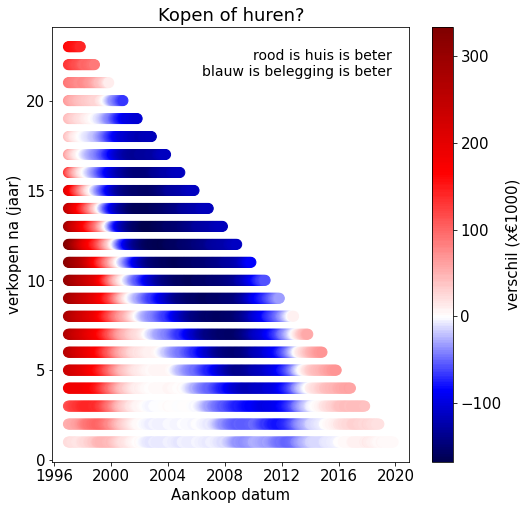

In [14]:
import matplotlib.colors

fig, ax = plt.subplots()
df.plot.scatter(
    ax=ax,
    x="aankoop_datum",
    y="aantal_jaar",
    c="verschil",
    s=100,
    alpha=1,
    norm=matplotlib.colors.TwoSlopeNorm(0),
    cmap="seismic",
    title="Kopen of huren?",
    xlabel="Aankoop datum",
    ylabel="verkopen na (jaar)",
    figsize=(8, 8),
)
ax, cax = plt.gcf().get_axes()
cax.set_ylabel("verschil (x€1000)")
ax.text(
    0.95,
    0.95,
    "rood is huis is beter\nblauw is belegging is beter",
    horizontalalignment="right",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=14,
)
plt.show()

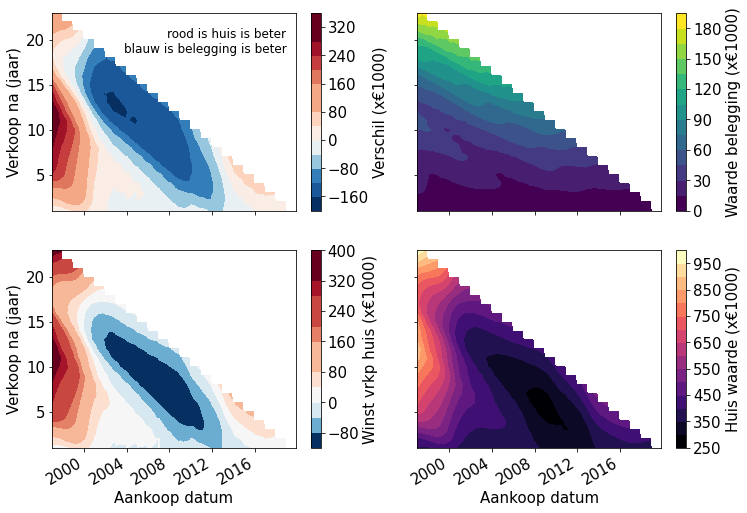

In [98]:
ds = df.set_index(["aantal_jaar", "aankoop_datum"]).to_xarray()
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex=True, sharey=True)
levels= 15
ds.verschil.plot.contourf(
    ax=axs[0, 0],
    norm=matplotlib.colors.TwoSlopeNorm(
        0, vmin=ds.verschil.min(), vmax=ds.verschil.max()
    ),
    add_colorbar=True,
    levels=levels,
    cbar_kwargs={"label": "Verschil (x€1000)"},
)
(ds.belegging / 1000).plot.contourf(
    ax=axs[0, 1],
    add_colorbar=True,
    levels=levels,
    cbar_kwargs={"label": "Waarde belegging (x€1000)"},
)
(ds.huis_winst / 1000).plot.contourf(
    ax=axs[1, 0],
    add_colorbar=True,
    levels=levels,
    norm=matplotlib.colors.TwoSlopeNorm(
        0, vmin=ds.huis_winst.min() / 1000, vmax=ds.huis_winst.max() / 1000
    ),
    cbar_kwargs={"label": "Winst vrkp huis (x€1000)"},
)
(ds.huis_waarde / 1000).plot.contourf(
    ax=axs[1, 1],
    add_colorbar=True,
    cbar_kwargs={"label": "Huis waarde (x€1000)"},
    cmap="magma",
    levels=levels,
)

axs[0, 0].text(
    0.6,
    0.95,
    "rood is huis is beter\nblauw is belegging is beter",
    horizontalalignment="right",
    verticalalignment="top",
    transform=ax.transAxes,
    fontsize=12,
)

axs[1, 0].set_xlabel("Aankoop datum")
axs[1, 1].set_xlabel("Aankoop datum")
axs[0, 0].set_ylabel("Verkoop na (jaar)")
axs[1, 0].set_ylabel("Verkoop na (jaar)")
axs[0, 0].set_xlabel("")
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("")
axs[1, 1].set_ylabel("")
plt.show()

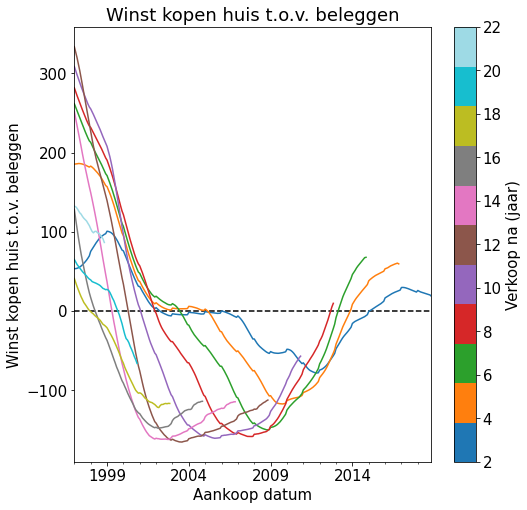

In [97]:
jaren = df.aantal_jaar.unique()[1::2]
cmap = matplotlib.cm.get_cmap("tab20", len(jaren))
color_map = dict(zip(sorted(jaren), cmap.colors))

fig, ax = plt.subplots(figsize=(8, 8))
a, b = df.aantal_jaar.min(), df.aantal_jaar.max()
for jaar in jaren:
    df[df.aantal_jaar == jaar].plot(
        x="aankoop_datum", y="verschil", ax=ax, color=color_map[jaar], legend=False
    )
cbar = fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap=cmap),
    ax=ax,
)
cbar.set_ticks(np.linspace(0, 1, len(jaren)))
cbar.set_ticklabels([int(j) for j in color_map.keys()])
cbar.set_label("Verkoop na (jaar)")
ax.hlines(
    0, df.aankoop_datum.min(), df.aankoop_datum.max(), ls="--", color="k", zorder=-1
)
ax.set_xlabel("Aankoop datum")
ax.set_ylabel("Winst kopen huis t.o.v. beleggen")
ax.set_title("Winst kopen huis t.o.v. beleggen")
plt.show()

## Conclusie

In het bovenstaande plaatje zien we lijnen die het verschil tussen een huis kopen en beleggen aangeven.
De kleur van de lijn geeft aan na hoe lang je het huis verkoopt.
Zo zien we dat als je de lijn van 8 jaar volgt hij net boven nul uitkomt bij ≈2013.
Dit betekent dat als je in 2013 een huis had gekocht en na 8 jaar wilde verkopen (dus in 2021), je net marginaal beter presteerde dan de aandelenmarkt.
Met de parameters die ik gekozen heb lijkt het erop de laatste 8 jaar het dus een goed idee was om een huis te kopen. Als je ongeveer 10 jaar in een huis wilt wonen, dan had je tussen 2000 en 2013 beter kunnen huren en de rest van je geld kunnen investeren.